In [9]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow.keras.datasets.mnist as mnist
from sklearn.metrics.pairwise import cosine_distances

In [10]:
(xtrain_raw,ytrain_raw),(xtest_raw,ytest_raw) = mnist.load_data()


training_index = np.zeros(len(ytrain_raw))
ytrain_count = np.zeros(10)
pics_limit = 500
for i in range(len(ytrain_raw)):
    if ytrain_count[ytrain_raw[i]] < pics_limit: 
        training_index[i] = 1
        ytrain_count[ytrain_raw[i]] +=1
        

training_index = training_index>0
xtrain = xtrain_raw[training_index]
ytrain = ytrain_raw[training_index]

numfeatures = 784
xtrain = np.reshape(xtrain,(len(xtrain),784))




### K_means with cosine distance

In [11]:
num_ks = np.array([5,10,20,40,200])
#num_ks = np.array([5,10])
iterations = 100
thr = 0.002
cluster_cons = np.zeros(len(num_ks)) 
cluster_cons_ptr = 0
np.random.seed(seed=115)

In [12]:
for kk in num_ks:
    
    #pick up k points as initial point
    k_ind = np.random.choice(range(len(ytrain)), size =kk, replace=False)

    k_loc = xtrain[k_ind,:]
    
    # initialize parameters
    prev_label = np.zeros(len(ytrain))-1 # sotre previous label for 
    label = np.zeros(len(ytrain))
    count = 0
    err = 1
    distances = np.zeros((len(ytrain),kk))
    
    # iterate untill the kernel converge
    while (count<iterations) and (err > thr):

        for i in range(kk):
            #print(k_loc[i].reshape(1,-1))
            distances[:,i] = cosine_distances(xtrain,k_loc[i].reshape(1,-1)).flatten()
            
        #get new label
        label = np.argmin(distances,axis = 1)
        #get error
        err = np.sum(prev_label!=label)/len(label)
        
        # update kmean, prev label and count
        
        for i in range(kk):
            if np.sum(label == i) !=0:
                k_loc[i,:] = np.mean(xtrain[label == i].reshape(-1,numfeatures),axis = 0)
        
        prev_label = label
        count+=1
    # calculate the cluster consistency
    print(kk)
    qi = np.zeros(kk)
    
    for i in range(kk):
        label_counts = np.zeros(10)
        cluster_points = ytrain[label==i]
        
        for j in range(10):
            label_counts[j] = np.sum(cluster_points == j)
            
        
        qi[i] = np.max(label_counts)*1.0/(len(cluster_points)*1.0)
    cluster_cons[cluster_cons_ptr] = np.mean(qi)
    
    cluster_cons_ptr+=1
    

5
10
20
40
200


In [13]:
cluster_cons

array([0.39495438, 0.60525426, 0.76858357, 0.84167706, 0.87367876])

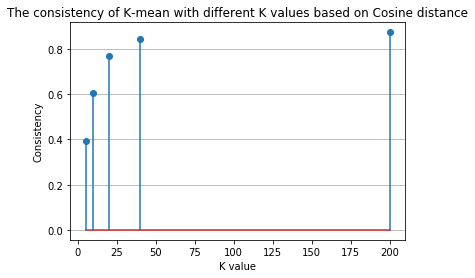

In [14]:
fig, ax = plt.subplots()

ax.stem(num_ks, cluster_cons)

#ax.set(xlim=(0, 6),ylim=(95, 100))
plt.title('The consistency of K-mean with different K values based on Cosine distance')
plt.xlabel('K value')
plt.ylabel('Consistency')
plt.grid(axis = 'y')
plt.show()

In [20]:
shu = np.zeros(len(xtrain))
for i in range(len(xtrain)):
    ai = np.mean(np.sum((xtrain[label[i]==label]-xtrain[i])**2,axis = 1))
    bi = np.mean(np.sum((xtrain[label[i]!=label]-xtrain[i])**2,axis = 1))
    shu[i] = max(ai,bi)/(bi-ai)
shu_mean = np.mean(shu)    

In [21]:
print('The average Silhouette Score is '+ str(shu_mean)) 

The average Silhouette Score is 19.696821463770544


### K_means with Mohalanobis distance

In [7]:
cluster_cons = np.zeros(len(num_ks)) 
cluster_cons_ptr = 0
iterations = 25
np.random.seed(seed=115)



In [8]:
for kk in num_ks:
    
    # set up default covaraince inverse matrix
    inv_cov = np.zeros((kk,np.shape(xtrain)[1],np.shape(xtrain)[1]))
    
    initial_inv_cov = np.linalg.inv(np.cov(xtrain.T))
    for i in range(kk):
        inv_cov[i] =  initial_inv_cov
    
    #pick up k points as initial point
    k_ind = np.random.choice(len(ytrain), size= kk,replace=False)
    k_loc = xtrain[k_ind,:]
    
    
    # initialize parameters
    prev_label = np.zeros(len(ytrain))-1 # sotre previous label for 
    
    
    label = np.zeros(len(ytrain))
    count = 0
    err = 1
    distances = np.zeros((len(ytrain),kk))
    
    
    # iterate untill the kernel converge
    while (count<iterations) and (err > thr):
        for i in range(kk):
            distances[:,i] = np.diagonal(np.dot(np.dot(xtrain-k_loc[i,:].reshape(1,-1),inv_cov[i]),(xtrain-k_loc[i,:].reshape(1,-1)).T))
            
        #get new label
        label = np.argmin(distances,axis = 1)
        #get error
        err = np.sum(prev_label!=label)/len(label)
        
        # update kmean, prev label, covariance and count
        
        for i in range(kk):
            if np.sum(label == i) >1:
                k_loc[i,:] = np.mean(xtrain[label == i],axis = 0)
            if np.linalg.det(np.cov(xtrain[label==i].T)) !=0:

                inv_cov[i] = np.linalg.inv(np.cov(xtrain[label==i].T))
        prev_label = label
        count+=1
    # calculate the cluster consistency
    qi = np.zeros(kk)
    for i in range(kk):
        if np.sum(label==i) !=0:
            
            label_counts = np.zeros(10)
            cluster_points = ytrain[label==i]
        
            for j in range(10): 
                label_counts[j] = np.sum(cluster_points == j)  
            qi[i] = np.max(label_counts)*1.0/(len(cluster_points)*1.0)

    cluster_cons[cluster_cons_ptr] = np.mean(qi)
    
    cluster_cons_ptr+=1

C:\Users\KakA\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\KakA\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\kaka\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\KakA\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\KakA\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\KakA\AppData\Roaming\Python\Python36\site-packages\numpy\linalg\linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r =

In [9]:
cluster_cons 

array([0.02  , 0.01  , 0.005 , 0.0025, 0.0005])

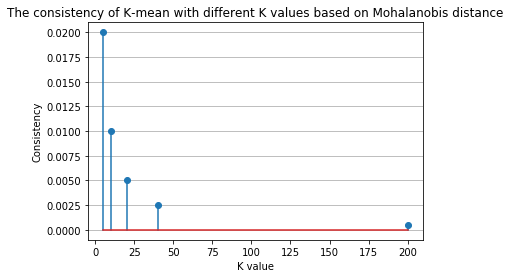

In [10]:
fig, ax = plt.subplots()

ax.stem(num_ks, cluster_cons)

#ax.set(xlim=(0, 6),ylim=(95, 100))
plt.title('The consistency of K-mean with different K values based on Mohalanobis distance')
plt.xlabel('K value')
plt.ylabel('Consistency')
plt.grid(axis = 'y')
plt.show()

1.1876344437017634e+99

In [3]:
import numpy as np
aa = np.array([[1,2],[3,4],[5,6]])


In [4]:
aa

array([[1, 2],
       [3, 4],
       [5, 6]])

In [8]:
np.mean(np.sum((aa-aa[1])**2,axis = 1))

array([8, 0, 8], dtype=int32)